In [1]:
!pip install segmentation_models

In [1]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [0]:
class Dataset:

    CLASSES = ['road', 'void']

    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        classes=None, 
        augmentation=None, 
        preprocessing=None):
      self.ids = os.listdir(images_dir)
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
      
      # convert str names to class values on masks
      self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
      
      self.augmentation = augmentation
      self.preprocessing = preprocessing

    def __getitem__(self, i):
      
      # read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_fps[i], 0)
      
      # extract certain classes from mask (e.g. cars)
      masks = [(np.ceil(mask / 255.0) == v) for v in self.class_values]
      mask = np.stack(masks, axis=-1).astype('float')
      
      # add background if mask is not binary
      if mask.shape[-1] != 1:
          background = 1 - mask.sum(axis=-1, keepdims=True)
          mask = np.concatenate((mask, background), axis=-1)
      
      # apply augmentations
      if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
      
      # apply preprocessing
      if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
          
      return image, mask
      
    def __len__(self):
        return len(self.ids)

In [0]:
class Dataloder(keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [0]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['road']
LR = 0.0001
EPOCHS = 40
ROOT_FOLDER = "drive/My Drive/MIPT_MS_THESIS/styled_road_seg/"

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid')
optim = keras.optimizers.Adam(LR)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
train_dataset = Dataset(
    ROOT_FOLDER + "train/img/", 
    ROOT_FOLDER + "train/mask/", 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset = Dataset(
    ROOT_FOLDER + "val/img/", 
    ROOT_FOLDER + "val/mask/", 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [41]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
25/25 [==============================] - 74s 3s/step - loss: 1.0293 - accuracy: 0.3200 - val_loss: 1.2777 - val_accuracy: 0.1746
Epoch 2/40
25/25 [==============================] - 11s 447ms/step - loss: 0.6822 - accuracy: 0.7207 - val_loss: 1.6823 - val_accuracy: 0.4323
Epoch 3/40
25/25 [==============================] - 11s 459ms/step - loss: 0.6172 - accuracy: 0.8073 - val_loss: 0.8260 - val_accuracy: 0.6624
Epoch 4/40
25/25 [==============================] - 11s 448ms/step - loss: 0.5966 - accuracy: 0.8270 - val_loss: 0.7193 - val_accuracy: 0.7236
Epoch 5/40
25/25 [==============================] - 11s 454ms/step - loss: 0.5507 - accuracy: 0.8519 - val_loss: 0.6202 - val_accuracy: 0.7837
Epoch 6/40
25/25 [==============================] - 11s 450ms/step - loss: 0.5235 - accuracy: 0.8581 - val_loss: 0.6346 - val_accuracy: 0.8062
Epoch 7/40
25/25 [==============================] - 11s 459ms/step - loss: 0.5158 - accuracy: 0.8579 - val_loss: 0.6336 - val_accuracy: 0.7621
Ep

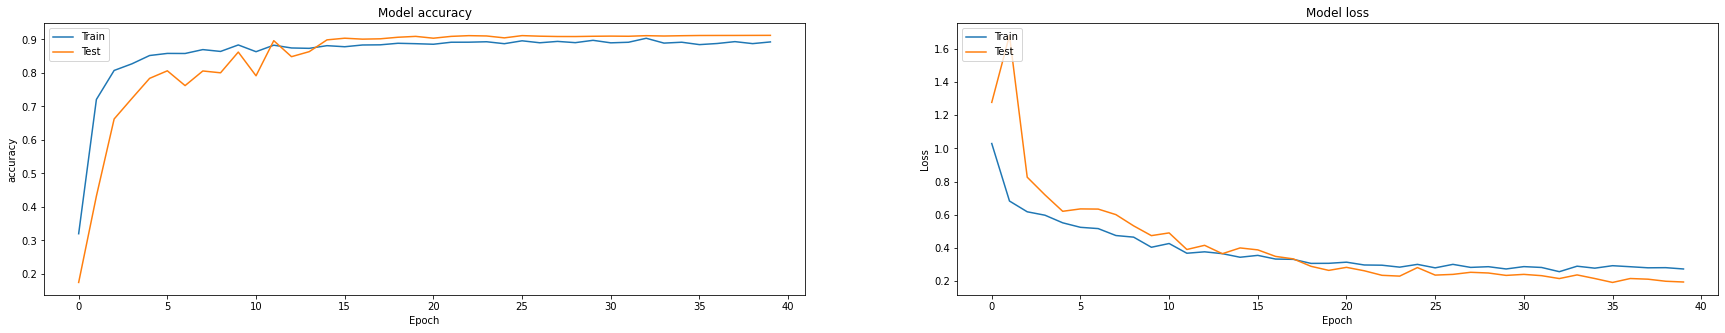

In [42]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
test_dataset = Dataset(
    ROOT_FOLDER + "test/img/", 
    ROOT_FOLDER + "test/mask/", 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [45]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
print("Accuracy: {:.5}".format(scores[1]))

Loss: 0.29207
Accuracy: 0.90326
